# Phase lock loop example

This notebook demonstrates a phase-lock loop with two YAG lasers. We will first show how to setup the IQ module to obtain a proper unwrapped phase error signal and then how to setup the different lock stage of the three outputs to obtain a stable lock with only a few degrees of error. 

:warning: **At the moment, the cordic phase estimator is only implemented in the branch 'new_pll'**

In [1]:
# Set environment variable to use a custom configuration file location
import os
os.environ["PYRPL_USER_DIR"] = "../pyrpl_user_dir/"

In [2]:
from pyrpl import Pyrpl
p = Pyrpl("pll_example")

C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
INFO:pyrpl:All your PyRPL settings will be saved to the config file
    ../pyrpl_user_dir/config\pll_example.yml
If you would like to restart PyRPL with these settings, type "pyrpl.exe pll_example" in a windows terminal or 
    from pyrpl import Pyrpl
    p = Pyrpl('pll_example')
in a python terminal.
INFO:pyrpl.redpitaya:Successfully connected to Redpitaya with hostname 192.168.1.111.
INFO:pyrpl.modules:Locked at stage 0: input cordicerror value is 0.52 +- 0.07 (setpoint 0.00).


## Configure lockbox parameters of the physical model

In [5]:
p.lockbox.classname = "Pll" # This instantiates a new Lockbox object with the right class
lockbox = p.lockbox
lockbox.eta = 0.9 # mode matching
lockbox.wavelength = 1064e-9

## Configure inputs

In [6]:
cordic_error = lockbox.inputs.cordicerror
lockbox.inputs.cordicerror.input_signal = 'iq1'

# Here we configure the IQ manually

iq = p.rp.iq1
iq.input ='in1'  # RF input of the RP on which the photo-diode picking up the beating of the two lasers is plugged
iq.frequency = 9e6 # frequecny at which you want to lock the laser
iq.acbandwidth = 3e6 # initial high pass filter on the input
iq.bandwidth = [3e6, 3e6] # second-order lowpass filter to get rid of the 2f component after demodulation
iq.output_signal = 'pfd'

In [7]:
lockbox.inputs.errorfastpiezo.input_signal = lockbox.outputs.fast_piezo

In [8]:
lockbox.inputs.errorslowpiezo.input_signal = lockbox.outputs.slow_piezo 

In [9]:
p.lockbox.inputs.errorslowpiezo.expected_slope(0)

-1.4777777777777779e-07

The inputs panel of the lockbox module should look like the following: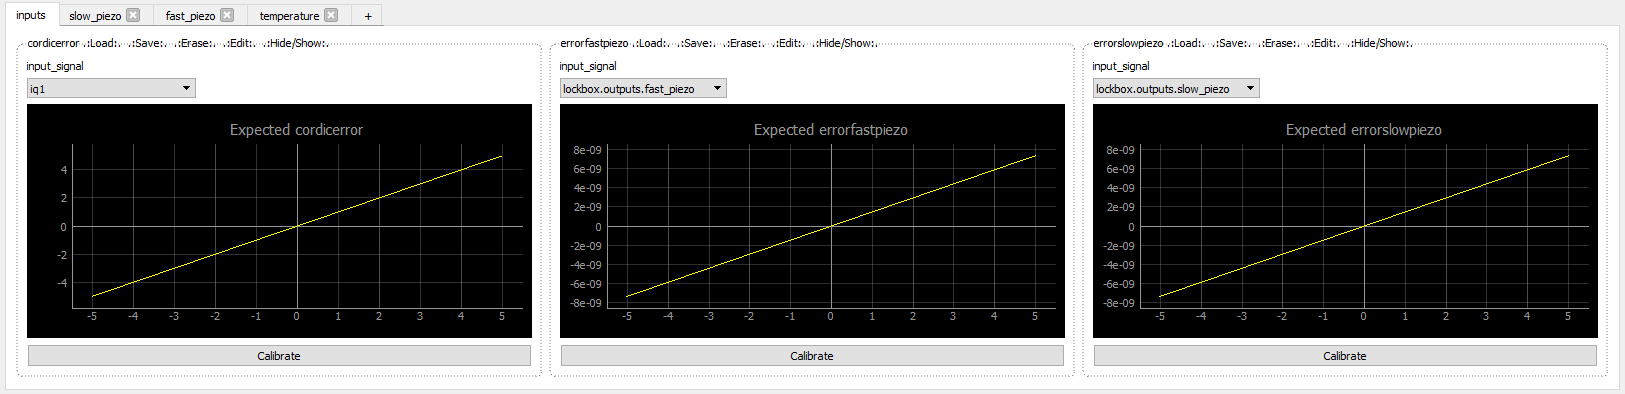

## Configure output


In [10]:
fast_piezo = lockbox.outputs.fast_piezo
fast_piezo.output_channel = 'out1'  # We use fast RF output of the RP for fast frequency feedback. 
#This output is plugged directly on the minus port of the piezo without filtering.  
fast_piezo.assisted_design = False
fast_piezo.dc_gain = 1e-9 
#fast_piezo.unit ='nm/V' #Here unit the unit 
fast_piezo.p = 3e-3
fast_piezo.i = 150

Output fast_piezo panel should look like the following: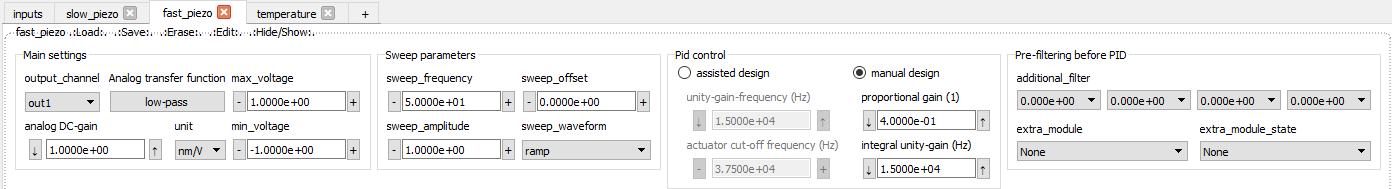

In [11]:
slow_piezo = lockbox.outputs.slow_piezo
slow_piezo.output_channel = 'pwm0' # We use the slow analog output0 from the RP. 
#This output is amplified by a factor 50 using a Tegam amplifier and low pass filtered before being plugged on the plus port of the piezo.
#So -1V -> 0V and 1V -> 100 V 
slow_piezo.assisted_design = False
slow_piezo.dc_gain = -1e-9
# slow_piezo.unit ='nm/V'
slow_piezo.p = 0.1
slow_piezo.i = 0.3

Output slow_piezo panel should look like the following: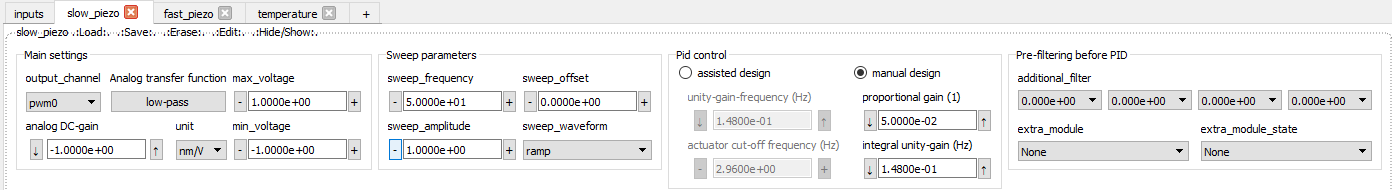

In [12]:
temperature = lockbox.outputs.temperature 
temperature.output_channel = 'pwm1' # We use the slow analog output1 from the RP. 
#This output is low pass filtered at 10 Hz and attenuated by 20 dB before being plugged to the laser crystal temperature controller.
temperature.assisted_design = False
temperature.dc_gain = 1e-9 
# temperature.unit ='nm/V'
temperature.p = 5e-2
temperature.i = 5e-4

Output temperature panel should look like the following: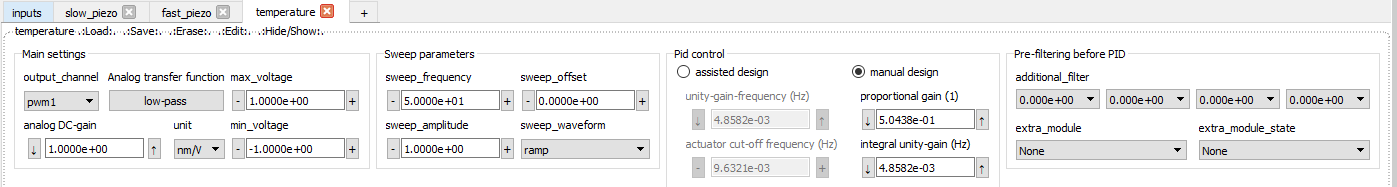

## Configure lock-acquisition sequence

In [13]:
sequence = p.lockbox.sequence

# remove all stages in the sequence (except for the first)
while len(p.lockbox.sequence)>1:
    p.lockbox.sequence.remove(p.lockbox.sequence[-1])

# configure first stage
stage0 = p.lockbox.sequence[0]
stage0.duration = 3
stage0.outputs.temperature.lock_on = False # Can be either True, False, or "ignore"
stage0.outputs.temperature.reset_offset = True # reset integrator offset at value defined below
stage0.outputs.temperature.offset = 0.3 # Sets the value of the temperature such that the beating peak is near our target frequency of 9 MHz
stage0.outputs.fast_piezo.reset_offset = True 
stage0.outputs.fast_piezo.offset = 0 # Reset the piezo in the middle of their range
stage0.outputs.slow_piezo.reset_offset = True 
stage0.outputs.slow_piezo.offset = 0 

# Create and configure second stage
sequence.append({})
stage1 = p.lockbox.sequence[1]
stage1.input = 'cordicerror'
stage1.setpoint = 0 # 0 phase difference between the beating and the RP internal reference
stage1.duration = 0.5 # time before switching to next stage
stage1.gain_factor = 100 # Gain to apply compared to output transfer function
stage1.outputs.fast_piezo.lock_on = True # start to lock the fast on the cordic error signal. Since they have a very small range they will saturate immediatly.

# Create and configure third stage
sequence.append({})
stage2 = p.lockbox.sequence[2]
stage2.outputs.fast_piezo.lock_on = "ignore" #keeps trying to lock the fast piezo as in stage 1 
stage2.input = 'errorfastpiezo' # we now use the fastpiezo output as our error signal and try to bring them in the middle of their range
stage2.outputs.slow_piezo.lock_on = True # using the slow piezo and their 100x bigger range
stage2.setpoint = 0 
stage2.gain_factor = 0.5 # Gain to apply compared to output transfer function

# Create and configure fourth stage
sequence.append({})
stage3 = p.lockbox.sequence[3]
stage3.outputs.fast_piezo.lock_on = "ignore" #keeps trying to lock the fast piezo as in stage 1 
stage3.outputs.slow_piezo.lock_on = "ignore" #keeps trying to lock the slow piezo as in stage 2 
stage3.input = 'errorslowpiezo' # we now use the slowpiezo output as our error signal and try to bring them in the middle of their range
stage3.outputs.temperature.lock_on = True # using the slow piezo and their 10x bigger range
stage3.setpoint = 0 
stage3.gain_factor = 10 # Gain to apply compared to output transfer function


INFO:pyrpl.modules:Locked at stage 0: input cordicerror value is 0.52 +- 0.09 (setpoint 0.00).
INFO:pyrpl.modules:Not locked: output fast_piezo is saturated.
INFO:pyrpl.modules:Locked at stage 3: input cordicerror value is 0.00 +- 0.00 (setpoint 0.00).


In [12]:
## Configure the scope in "rolling mode" (only allowed for duration >0.1s)

scope = p.rp.scope

scope.duration = 8
scope.rolling_mode = True
scope.input1 = 'iq1'
scope.input2 = 'out1'
scope.save_state('rolling_8s')

p.rp.scope.run_continuous = True

# launch the lock sequence
p.lockbox.lock()

INFO:pyrpl.modules:Locked at stage 0: input cordicerror value is 0.55 +- 0.07 (setpoint 0.00).


True

## Monitor beatnote spectrum while scanning Laser2 temperature

In [13]:
p.lockbox.default_sweep_output = "temperature"
p.lockbox.outputs.temperature.sweep_frequency = 0.1

p.lockbox.sweep()

cancel acquire


In [14]:
p.spectrumanalyzer.input1_baseband = "in1"
p.spectrumanalyzer.display_input2_baseband = False
p.spectrumanalyzer.display_cross_amplitude = False
p.spectrumanalyzer.display_cross_phase = False

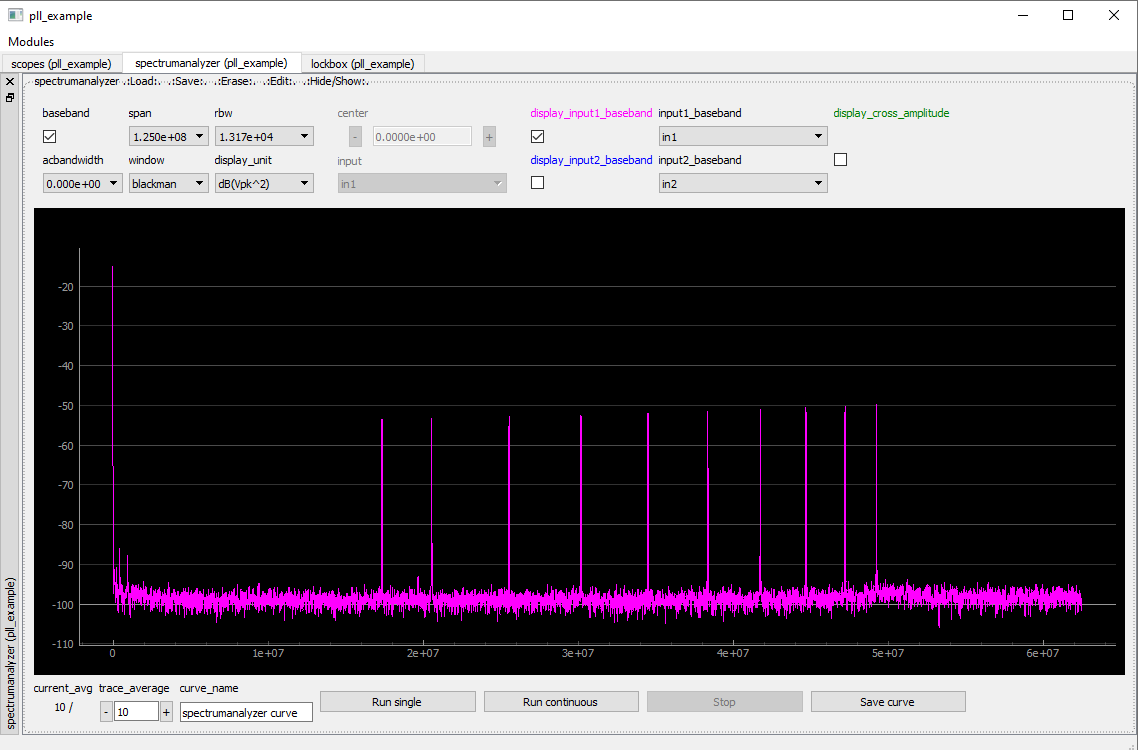

## Monitoring error signals during lock sequence 

In [27]:
OFFSET = 0.4
stage0 = p.lockbox.sequence[0]
stage0.outputs.temperature.offset = OFFSET
stage0.execute_async()

<Task pending name='Task-60078' coro=<Stage._execute_async() running at C:\Users\OMQ SQZ 2.0\Documents\GitHub\pyrpl\pyrpl\software_modules\lockbox\stage.py:156>>

INFO:pyrpl.modules:Not locked: output fast_piezo is saturated.
INFO:pyrpl.modules:Locked at stage 2: input cordicerror value is -0.00 +- 0.00 (setpoint 0.00).


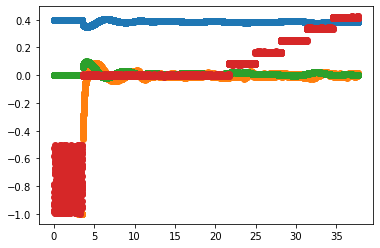

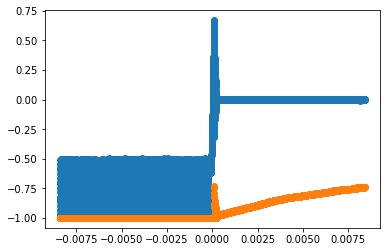

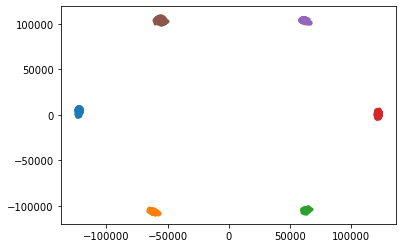

In [28]:
from timeit import default_timer
from pyrpl.async_utils import sleep, wait
from pylab import np, plt 

# We first lock the phase-lock loop, and then move the setpoint in a staircase fashion at different phase-difference values.
# In order to monitor the sequence at long time-scales, we use a computer-controlled sampler. 
# For short time-scales around the lock-acquisition, we use the scope in triggered mode.

# Parameters of the sampler acquisition:
N_SAMPLES = 10000  # data_points to sample during lock-acquisition
SAMPLING_TIME = 1e-3 #  Approximately 1 ms sampling time
channels = ["pid1", "pid2", "pid3", "iq1"] # channels to sample

# Sampler parameters for the staircase acquisition
setpoints = np.arange(0, 360, 60)/(2*360) # angle setpoints in cordic error signal units.
N_SAMPLES_SETPOINTS = 1000 # data-points to sample during each staircase-step.

# prepare empty data arrays 
sampler_vals = np.zeros((len(channels), N_SAMPLES + len(setpoints) * N_SAMPLES_SETPOINTS))
sampler_times = np.zeros(N_SAMPLES + len(setpoints) * N_SAMPLES_SETPOINTS)

# During the staircase sequence, we retrieve the position of the quadratures in the complex plane,
# using the na_data accumulator of the iq module.
iq = p.rp.iq1
iq._na_sleepcycles = 1 # Number of cycle to let the accumulator stabilize
p.rp.iq1._na_averages = 1000 # Number of cycles to accumulate data

# prepare empty array to store complex iq values
zs = np.zeros((len(setpoints), N_SAMPLES_SETPOINTS), dtype=complex)


# Scope configuration (trigger on cordic)
scope = p.rp.scope
scope.duration = 0.01  # 10 ms to be able to unwrap the phase of the cordic error signal close to the zero-detuning point
scope.input1 = 'iq1'   # cordic error signal
scope.input2 = 'out1'  # monitor fast piezo with the scope
scope.threshold = -0.2 # trigger when cordic approaches zero
scope.trigger_source = 'ch1_positive_edge'

# x-axis for plotting of scope curve
scope_times = scope.times

# Launch scope acquisition
res1 = scope.single_async() #Scope is now waiting for trigger

p.lockbox.lock_async() # start the lock sequence (asynchronous to be able to run the sampler in the meantime)

# Launch the sampler loop
for index_time in range(N_SAMPLES):
    for index_channel, ch in enumerate(channels): # Loop on all desired channels
        sampler_vals[index_channel, index_time] = getattr(p.rp.sampler, ch) # any internal signal can be sampled 
                                                                            #via p.rp.sampler.ch_name 
    sampler_times[index_time] = default_timer() # More accurate than time.time()
    sleep(SAMPLING_TIME) # use pyrpl.async_utils.sleep instead of time.sleep() in order not to lock the event-loop

# Loop over staircase setpoints
for index_setpoint, setpoint in enumerate(setpoints):
    p.lockbox.outputs.fast_piezo.pid.setpoint = setpoint # move the cordic angle setpoint
    for index_time in range(N_SAMPLES_SETPOINTS):    # Sampler loop for staircase acquisition 
        for index_channel, ch in enumerate(channels):# loop over channels
            sampler_vals[index_channel, N_SAMPLES + index_setpoint*N_SAMPLES_SETPOINTS + index_time] = \
                                                                                    getattr(p.rp.sampler, ch)
            iq.frequency = 9e6 # Reset the na_data accumulator of the iq by resetting the frequency register
            zs[index_setpoint, index_time] = iq._nadata_total/iq._na_averages # retrieve na data 
        sampler_times[N_SAMPLES + index_setpoint*N_SAMPLES_SETPOINTS + index_time] = default_timer() # time of sampled data
    sleep(SAMPLING_TIME) # pyrpl.async_utils.sleep in order not to block the event-loop
    
# Wait for scope result (zoom on the lock acquisition)
scope_vals = wait(res1) 

# Quick plot to control data-quality
plt.close("all") # close all figures
plt.figure() # create new figure for sampler data
plt.plot(sampler_times - sampler_times[0], sampler_vals.T, 'o') 

plt.figure() # create new figure for scope data
plt.plot(scope_times, scope_vals.T, 'o')

plt.figure() # create new figure for iq data
plt.plot(np.real(zs).T, np.imag(zs).T, '.')

In [33]:
# save data
np.save('./data/sampler_times_vals.npy', [sampler_times, sampler_vals])
np.save('./data/scope_times_vals.npy', [scope_times, scope_vals])
np.save('./data/iq_setpoints_zs.npy', [setpoints, zs.T])

In [ ]:
# Save data
import h5py


#   sampler_vals_loaded

kwds = dict(sampler_times=sampler_times,
           sampler_vals=sampler_vals)

with h5py.File("./data/sampler_times_vals.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)  
        
        
#   scope_times_vals

kwds = dict(scope_times=scope_times,
           scope_vals=scope_vals)

with h5py.File("./data/scope_times_vals.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)
        
             
#   iq_setpoints_zs

kwds = dict(setpoints=setpoints,
           iq_vals=zs.T)

with h5py.File("./data/iq_setpoints_zs.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)
 

## Monitor the beatnote spectrum during lock-acquisition

In [67]:
OFFSET = 0.52
stage0 = p.lockbox.sequence[0]
stage0.outputs.temperature.offset = OFFSET
stage0.execute_async()

<Task pending name='Task-80236' coro=<Stage._execute_async() running at C:\Users\OMQ SQZ 2.0\Documents\GitHub\pyrpl\pyrpl\software_modules\lockbox\stage.py:156>>

INFO:pyrpl.modules:Not locked: output fast_piezo is saturated.


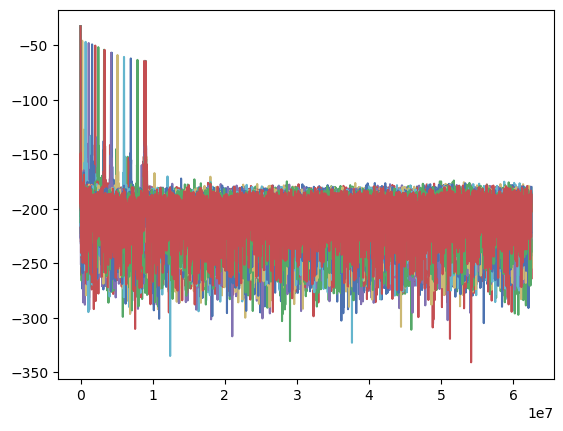

INFO:pyrpl.modules:Locked at stage 2: input cordicerror value is -0.00 +- 0.00 (setpoint 0.00).


In [68]:
from timeit import default_timer
spectra = []
times_spectra = []
p.lockbox.sequence[0].execute()
p.lockbox.sequence[1].execute()

spectra.append(p.spectrumanalyzer.single()[0])
times_spectra.append(default_timer())
p.lockbox.sequence[2].execute()

freqs_sa = p.spectrumanalyzer.frequencies
for i in range(20):
    spectra.append(p.spectrumanalyzer.single()[0])
    times_spectra.append(default_timer())
plt.figure()
plt.plot(freqs_sa, 20*np.log10(np.abs(np.array(spectra).T)))

In [18]:
#save beatnote data 
mask = (freqs_sa<10e6) #to save disk space, only save up 10 MHz 
kwds = dict(freqs_sa=freqs_sa[mask],
           times_spectra=times_spectra,
           spectra=spectra[:, mask])

with h5py.File("./data/spectra_beatnote.h5", 'w') as f:
    for key, value in kwds.items():
        dset = f.create_dataset(key, data=value)


## Plot the PLL frequencies over time 

In [2]:
import h5py
from pylab import np, plt 

# load data
kwds = {}
with h5py.File("./data/spectra_beatnote.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
freqs_spectra_loaded = kwds["freqs_sa"]
times_spectra_loaded = kwds["times_spectra"]
spectra_loaded = kwds["spectra"]
spectra_loaded = np.array(spectra_loaded)

# clean data
mask = (freqs_spectra_loaded<10e6) * (freqs_spectra_loaded>0.1e6)
spectra_loaded = 20*np.log10(np.abs(spectra_loaded))
spectra_loaded = spectra_loaded[:, mask]
spectra_loaded = spectra_loaded[:,slice(0,-1,5)]  #downsample

freqs_spectra_loaded = freqs_spectra_loaded[mask]
freqs_spectra_loaded = freqs_spectra_loaded[slice(0,-1,5)]

times_spectra_loaded = np.array(times_spectra_loaded)-times_spectra_loaded[0]


In [6]:
from pylab import np, plt 

def plot2din3d(x, y, z, idx, ymin, thickness_min=10):
    """
    
    """
    d_col_obj = ax.plot(x/1e6, y, zs=z, zdir='x', color=plt.cm.viridis(1-idx/len(spectra_loaded)), linewidth=0.2, rasterized = True)
    
    y[y<ymin] = ymin
    d_col_obj = ax.fill_between(x/1e6, ymin - thickness_min, y, alpha=0.3, where=(y>ymin), color=plt.cm.viridis(1-idx/len(spectra_loaded)), rasterized = True) 
    ax.add_collection3d(d_col_obj, zs = z, zdir = 'x')
    
    ax.set_zlim(ymin)
    ax.set_box_aspect((3,3,1))
    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel(r'Beatnote PSD (dB)', rotation=90 , fontsize = 12)
    ax.grid(False)

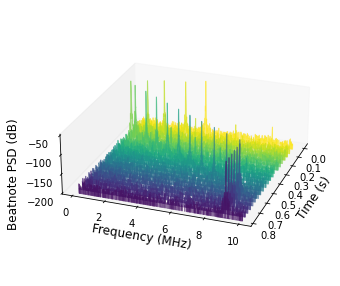

In [10]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection="3d")
 
for idx, y in enumerate(spectra_loaded): 
    plot2din3d(freqs_spectra_loaded, y, times_spectra_loaded[idx], idx, -200)

ax.view_init(elev=25., azim=20)
ax.set_zticks([-50, -100, -150, -200])
plt.axis('on')
plt.xlabel(r'Time (s)', fontsize = 12)
plt.ylabel(r'Frequency (MHz)', fontsize = 12)
plt.show()

fig.savefig("./figure_beatnote.svg", dpi=100)

# Plot cordic errors within a lock sequence

In [12]:
import h5py

#load data subfigure1
kwds = {}
with h5py.File("./data/sampler_times_vals.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
sampler_times_loaded = kwds["sampler_times"]
sampler_vals_loaded = kwds["sampler_vals"]


#load data subfigure2
kwds = {}
with h5py.File("./data/scope_times_vals.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
scope_times_loaded = kwds["scope_times"]
scope_vals_loaded = kwds["scope_vals"]


#load data subfigure3
kwds = {}
with h5py.File("./data/iq_setpoints_zs.h5", 'r') as f:
    for key in f.keys():
        kwds[key] = f[key][...]
setpoints_loaded = kwds["setpoints"]
iq_vals_loaded = kwds["iq_vals"]

sampler_times_loaded -= sampler_times_loaded[0]

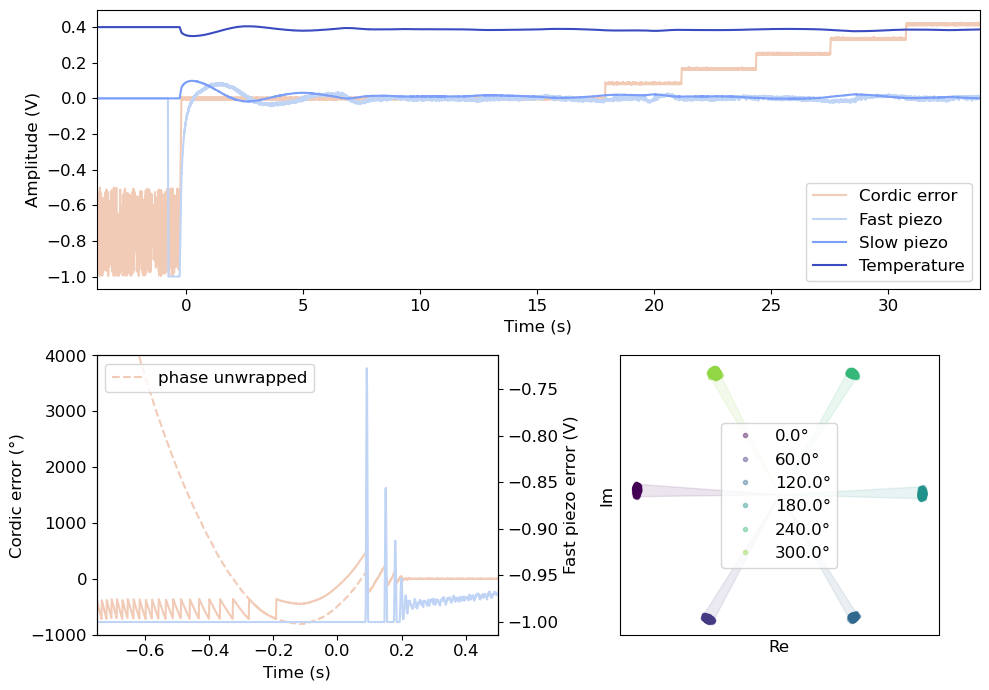

In [13]:
from pylab import np, plt 

TIME_TRIGGER = 3.8

# Customize matplotlib style
plt.style.use('default')
plt.style.use('seaborn-deep')

# Choose line colors from colormap
CMAP = plt.cm.coolwarm
cordic_color = CMAP(0.6)
fast_piezo_color = CMAP(0.4)
slow_piezo_color = CMAP(0.2)
temperature_color = CMAP(0.)

temperature_loaded, fast_piezo_loaded, slow_piezo_loaded, cordic_loaded = sampler_vals_loaded

fig = plt.figure(figsize=(10, 7))

ax1 = plt.subplot(211)

sampler_times_loaded -= TIME_TRIGGER

plt.plot(sampler_times_loaded, cordic_loaded, color=cordic_color, label="Cordic error", rasterized=True)
plt.plot(sampler_times_loaded, fast_piezo_loaded, color=fast_piezo_color, label="Fast piezo", rasterized=True)
plt.plot(sampler_times_loaded, slow_piezo_loaded, color=slow_piezo_color, label="Slow piezo", rasterized=True)
plt.plot(sampler_times_loaded, temperature_loaded, color=temperature_color, label="Temperature", rasterized=True)
plt.legend(fontsize=12)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Amplitude (V)', fontsize=12)
ax1.set_xlim(min(sampler_times_loaded), max(sampler_times_loaded))
ax1.tick_params(axis='both', labelsize=12)



ax2 = plt.subplot(223)

cordic_scope_loaded, fast_piezo_scope_loaded = scope_vals_loaded
cordic_unwrapped = np.unwrap(cordic_scope_loaded*(2*360) , period=360)
cordic_unwrapped-=cordic_unwrapped[-1]
plt.plot(scope_times_loaded*1e3, cordic_unwrapped, color=cordic_color, linestyle='dashed', label='phase unwrapped', rasterized=True)
plt.plot(scope_times_loaded*1e3, cordic_scope_loaded*(2*360), color = cordic_color, rasterized=True)
plt.legend(loc='upper left', fontsize=12)
plt.ylim(-1000,4000)
ax2.set_ylabel('Cordic error (°)', fontsize=12)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.tick_params(axis='both', labelsize=12)

ax_twin = ax2.twinx()
#ax_twin.plot(scope_times_loaded*1e3, cordic_scope_loaded*(2*360), color = cordic_color)
ax_twin.plot(scope_times_loaded*1e3, fast_piezo_scope_loaded, color=fast_piezo_color, rasterized=True)
ax_twin.set_ylabel('Fast piezo error (V)', fontsize=12)
ax_twin.tick_params(axis='both', labelsize=12)
plt.xlim(-0.75, 0.5)





from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection





ax3 = plt.subplot(224)
#plt.plot(np.real(iq_vals_loaded), np.imag(iq_vals_loaded), '.')
ax3.set_aspect("equal")

patches =  []
colors =  []
for index, data in enumerate(iq_vals_loaded.T): 
    plt.plot(np.real(data), np.imag(data), '.', alpha=0.4, label=str(setpoints_loaded[index]*2*360)+'°' , 
             color=plt.cm.viridis(index/len(iq_vals_loaded.T)), rasterized=True)
    
    if index==0: angle = (np.angle(data))%(2*np.pi)
    else : angle = (np.angle(data)+np.pi)%(2*np.pi)
    
    zmax = data[np.argmax(angle)]
    zmin = data[np.argmin(angle)]
    pts = [[0,0] , 
           [np.real(zmin) , np.imag(zmin)],
           [np.real(zmax) , np.imag(zmax)]]
    
    
    colors.append(plt.cm.viridis(index/len(iq_vals_loaded.T)))
    polygon = Polygon(pts, True , color=plt.cm.viridis(index/len(iq_vals_loaded.T)))
    patches.append(polygon)
    
    
    
p = PatchCollection(patches, alpha=0.1)
p.set_color(colors)

ax = plt.gca()
ax.add_collection(p)
    
plt.legend(frameon=True , ncol=1 , fontsize=12, loc='center')
plt.xlabel(r'Re' , fontsize=12)
plt.ylabel(r'Im' , fontsize=12)
plt.xticks([])
plt.yticks([])
fig.tight_layout()
plt.show()

fig.savefig("./figure_cordic_error.svg", dpi=200)

## Open loop measurement

In [11]:
import numpy as np
from pyrpl.async_utils import sleep, wait

POINTS_PER_DECADE_LF = 50 # Number of points per decade in the low frequency region of the scan
POINTS_PER_DECADE_HF = 300 # Number of points per decade in the high frequency region of the scan

def ramp_na(amplitude):
    """
    Convenience function to make sure the network analyzer is slowly ramping up/down in amplitude.
    This avoids strong discontinuities that tend to unlock the loop.
    """
    for amp in np.linspace(p.networkanalyzer.iq.amplitude, amplitude, 10):
        p.networkanalyzer.iq.amplitude = amp
        sleep(0.03)
        
zs = []    # Closed-loop transfer functions
freqs = [] # Measured frequencies
index = 0  

# In order to maximize signal-to-noise ratio, the amplitude and bandwidth of the NA
# are adjusted piecewise along the scan
starts_amps_ppd = [#(5, 0.2, POINTS_PER_DECADE_LF), # from 5 to 10 Hz, amplitude=0.5, fewer points to speed-up acquisition
                   (10, 0.1, POINTS_PER_DECADE_LF),   # 10 to 50 Hz
                   (30, 0.05, POINTS_PER_DECADE_LF),   # 50 to 100 Hz
                   (100, 0.05, POINTS_PER_DECADE_LF), # 100 to 200 Hz
                   (200, 0.01, POINTS_PER_DECADE_LF), # 0.2 to 5 kHz
                   (5000, 0.01, POINTS_PER_DECADE_HF), # 5 to 50 kHz  (RBW is adapted to each segment)
                   (50000, 0.001, POINTS_PER_DECADE_HF*10), # 50 to 500 kHz
                    (500000, 0.01, None)]

p.networkanalyzer.output_direct = "out1"
p.networkanalyzer.input = "out1"
p.networkanalyzer.acbandwidth = 4
p.networkanalyzer.average_per_point = 1
p.networkanalyzer.logscale = True
p.networkanalyzer.trace_average = 1

# amplitude, rbw, start and stop_freq will be set dynamically during the acquisition


for index, (start, amp, ppd) in enumerate(starts_amps_ppd[:-1]):
    ramp_na(0) # Slowly set na output to 0
    p.networkanalyzer.start_freq = start  # Set na start frequency for the current segment
    stop = starts_amps_ppd[index+1][0]    # Use start of next segment as stop frequency
    p.networkanalyzer.stop_freq = stop    # Set na stop frequency for the current segment
    p.networkanalyzer.amplitude = 0       # Network analyzer is set at 0 amplitude to avoid discontinuity
                                          # (ramp-up will be achieved manually after the scan has started)
    p.networkanalyzer.rbw = min(start/50, 75) # RBW can be made larger at high frequency (2f rejection)
    p.networkanalyzer.points = int(np.round(np.log10(stop/start)*ppd)) # the density of points should be  
                                                                       # uniform in a log-scale
    res = p.networkanalyzer.single_async() # Launch acquisition for this segment
    ramp_na(amp)                           # Ramp-up the amplitude slowly
    zs+=list(wait(res)[1:])                   # append data to the list (remove first duplicate point)
    freqs+=list(p.networkanalyzer.frequencies[1:]) # append the frequencies to the list
zs = np.array(zs)  # measured closed-loop transfer function 
freqs = np.array(freqs) # frequencies
zpids = p.rp.pid2.transfer_function(freqs) # Known transfer function of the pid controller (all DSP modules have a 
                                           # transfer_function method)
    
### Plot result (raw)
import matplotlib.pyplot as plt


def bode_plot(freqs, zs, axes=None, label=None, color=None, linestyle=None):
    """
    Plots the magnitude and phase of a complex series.
    """
    if axes is None:
        fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].semilogx(freqs, 20*np.log10(np.abs(zs)), linestyle=linestyle, color=color, label=label)
    axes[1].semilogx(freqs, 180/np.pi*np.angle(zs), linestyle=linestyle, color=color, label=label)
    axes[0].set_xlim(min(freqs), 2e5)
    axes[1].set_ylim(-200, 200)
    axes[1].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Amplitude (dB)")
    axes[1].set_ylabel(r"Phase ($^\circ$)")

    axes[0].set_yticks([-60, -30, 0, 30, 60])
    axes[1].set_yticks([-180, -90, 0, 90, 180, 180])
    axes[0].tick_params(axis='x', which='minor', bottom=True)
    axes[1].tick_params(axis='x', which='minor', bottom=True)
    axes[0].grid(True)
    axes[1].grid(True)
    plt.subplots_adjust(hspace=0.2, top=0.93)
    return axes


axes = bode_plot(freqs, zs.T, label='closed-loop tf')
plant_open_loop = ((1 - 1/zs)/zpids)
bode_plot(freqs, plant_open_loop, axes=axes, label='plant tf')
open_loop_tf = (1 - 1/zs)
bode_plot(freqs, open_loop_tf, axes=axes, label='open-loop tf')
controller_tf = zpids
bode_plot(freqs, controller_tf, axes=axes, label='controller tf')
plt.suptitle("transfer function measurements")
plt.legend()

In [12]:
np.save(f'./data/freqs_zclosed_zpids_close.npy', [freqs, zs, zpids])
# Also save the external loop gain assumed by the lockbox at acquisition time 
# This dimensionless gain takes into the calibrated error signal and the dc_gain 
# entered in the "piezo" output of the lockbox.
np.save(f'./data/external_loop_gain.npy', [p.lockbox.outputs.fast_piezo.p/p.lockbox.outputs.fast_piezo.pid.p])

In [8]:
%pylab qt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\OMQ SQZ 2.0\.conda\envs\Nospace\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [13]:
from pylab import plt, np

# Load data
freqs, zs, zpids = np.load(r"./data/freqs_zclosed_zpids_close.npy")
external_loop_gain = np.load(r"./data/external_loop_gain.npy")

# Customize matplotlib style
plt.style.use('default')
plt.style.use('seaborn-deep')

# Redefine bode_plot in case the cells above have not been executed
def bode_plot(freqs, zs, axes=None, label=None, color=None, linestyle=None):
    """
    Plots the magnitude and phase of a complex series.
    """
    if axes is None:
        fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].semilogx(freqs, 20*np.log10(np.abs(zs)), linestyle=linestyle, color=color, label=label)
    axes[1].semilogx(freqs, 180/np.pi*np.angle(zs), linestyle=linestyle, color=color, label=label)
    axes[0].set_xlim(min(freqs), 2e5)
    axes[1].set_ylim(-200, 200)
    axes[1].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Amplitude (dB)")
    axes[1].set_ylabel(r"Phase ($^\circ$)")

    axes[0].set_yticks([-60, -30, 0, 30, 60])
    axes[1].set_yticks([-180, -90, 0, 90, 180, 180])
    axes[0].tick_params(axis='x', which='minor', bottom=True)
    axes[1].tick_params(axis='x', which='minor', bottom=True)
    axes[0].grid(True)
    axes[1].grid(True)
    plt.subplots_adjust(hspace=0.2, top=0.93)
    return axes

# Exclude first point
freqs = np.real(freqs[1:])
zs = zs[1:]
zpids = zpids[1:]

# Choose line colors from colormap
CMAP = plt.cm.coolwarm

# plot closed-loop transfer function
axes = bode_plot(freqs, zs, label="closed-loop", color=CMAP(0.), linestyle='-')

# plot pid transfer-function
bode_plot(freqs, -zpids, axes, label="controller", color=CMAP(.7), linestyle='--')

# plot plant transfer-function
plant = -(1-1/zs)/zpids
bode_plot(freqs, plant, axes, label="plant", color=CMAP(0.2), linestyle='-')

# plot open-loop transfer function
open_loop = -(1-1/zs)
bode_plot(freqs, open_loop, axes, label="open-loop", color="k")

# plot RC-model plant transfer-function
freq0 = 40
plant_rc = external_loop_gain/(1+1j*freqs/freq0)
bode_plot(freqs, plant_rc, axes=axes, color=CMAP(1.), label='plant (RC-model)', linestyle='--')
plt.suptitle("Transfer functions")


# find the open-loop unit-gain frequency
index_0db = (np.abs(open_loop)<1).nonzero()[0][0]
freq_0db = freqs[index_0db]
angle_0db = 180/np.pi*np.angle(open_loop[index_0db])

# plot a red marker on the unit-gain point
axes[0].plot([freq_0db], [0], 'or', markerfacecolor='None')
axes[1].plot([freq_0db], [angle_0db], 'or', markerfacecolor='None')

# Add a double-arrow to indicate the phase margin
#axes[1].annotate(s='', xy=(freq_0db, angle_0db - 5), xytext=(freq_0db, angle_0db + 50), arrowprops=dict(arrowstyle='->'))
#axes[1].annotate(s='', xy=(freq_0db, -180 + 5), xytext=(freq_0db, -180-50), arrowprops=dict(arrowstyle='->'))

# Add plot legend
axes[0].legend(ncol=3, bbox_to_anchor=(1., -0.26), loc='lower right')
axes[0].set_zorder(100)